In [1]:
import warnings
import pathlib
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
seviri_path = pathlib.Path(r"/work/scratch-nopw2/wkjones/seviri_regrid")

In [3]:
regrid_files = sorted(list(seviri_path.glob("*.nc")))

In [4]:
len(regrid_files)

96

In [5]:
regrid_ds = xr.open_mfdataset(regrid_files, combine="nested", concat_dim="t")

In [6]:
regrid_ds = regrid_ds.assign_coords(t=pd.DatetimeIndex(
    pd.date_range(datetime(2021,7,1,4), datetime(2021,7,2,4), freq="900s", inclusive="left")
))

In [7]:
regrid_ds

<xarray.Dataset>
Dimensions:            (t: 96, y: 900, x: 900)
Coordinates:
  * y                  (y) float64 89.9 89.7 89.5 89.3 ... -89.5 -89.7 -89.9
  * x                  (x) float64 -89.9 -89.7 -89.5 -89.3 ... 89.5 89.7 89.9
    longitude          (y, x) float64 dask.array<chunksize=(900, 900), meta=np.ndarray>
    latitude           (y, x) float64 dask.array<chunksize=(900, 900), meta=np.ndarray>
  * t                  (t) datetime64[ns] 2021-07-01T04:00:00 ... 2021-07-02T...
Data variables:
    EPSG_4326_900x900  (t) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    bt                 (t, y, x) float32 dask.array<chunksize=(1, 900, 900), meta=np.ndarray>
    wvd                (t, y, x) float32 dask.array<chunksize=(1, 900, 900), meta=np.ndarray>
    swd                (t, y, x) float32 dask.array<chunksize=(1, 900, 900), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2024-11-13 07:00:38.028579
    Conventions:  CF-1.7

In [8]:
bt = regrid_ds.bt.load()
wvd = regrid_ds.wvd.load()
swd = regrid_ds.swd.load()

In [9]:
from tobac_flow.flow import create_flow

In [10]:
flow = create_flow(
    bt, model="Farneback", vr_steps=1, smoothing_passes=1, interp_method="linear"
)

In [11]:
wvd_threshold = 0.25
bt_threshold = 0.25
overlap = 0.5
absolute_overlap = 1
subsegment_shrink = 0.0
min_length = 2

In [12]:
from tobac_flow.detection import (
    detect_cores,
    get_anvil_markers,
    detect_anvils,
    relabel_anvils,
)
core_labels = detect_cores(
    flow,
    bt,
    wvd,
    swd,
    wvd_threshold=wvd_threshold,
    bt_threshold=bt_threshold,
    overlap=overlap,
    absolute_overlap=absolute_overlap,
    subsegment_shrink=subsegment_shrink,
    min_length=min_length,
    use_wvd=False,
)

/home/users/wkjones/python/tobac-flow/tobac_flow/detection.py:189: RuntimeWarning: Mean of empty slice
  func=lambda x: np.nanmean(x, 0),


BT growth above threshold: area = 191767
Detected markers: area = 37181
Initial core count: 3415
Core labels meeting length threshold: 319
Core labels meeting WVD threshold: 1672
Core labels meeting cooling rate threshold: 124


In [13]:
upper_threshold = -5
lower_threshold = -12.5
erode_distance = 2

anvil_markers = get_anvil_markers(
    flow,
    wvd - swd,
    threshold=upper_threshold,
    overlap=overlap,
    absolute_overlap=absolute_overlap,
    subsegment_shrink=subsegment_shrink,
    min_length=min_length,
)

print("Final thick anvil markers: area =", np.sum(anvil_markers != 0), flush=True)
print("Final thick anvil markers: n =", anvil_markers.max(), flush=True)

Final thick anvil markers: area = 2928537
Final thick anvil markers: n = 1434


In [14]:
thick_anvil_labels = detect_anvils(
    flow,
    wvd - swd,
    markers=anvil_markers,
    upper_threshold=upper_threshold,
    lower_threshold=lower_threshold,
    erode_distance=erode_distance,
    min_length=min_length,
)
print("Initial detected thick anvils: area =", np.sum(thick_anvil_labels != 0), flush=True)
print("Initial detected thick anvils: n =", thick_anvil_labels.max(), flush=True)

Initial detected thick anvils: area = 16177942
Initial detected thick anvils: n = 1434


In [15]:
thin_anvil_labels = detect_anvils(
    flow,
    wvd + swd,
    markers=thick_anvil_labels,
    upper_threshold=upper_threshold,
    lower_threshold=lower_threshold,
    erode_distance=erode_distance,
    min_length=min_length,
)

print("Detected thin anvils: area =", np.sum(thin_anvil_labels != 0), flush=True)
print("Detected thin anvils: n =", np.max(thin_anvil_labels), flush=True)

KeyboardInterrupt: 

In [2]:
frame = 44

In [53]:
seviri_ds = xr.open_dataset("seviri_tracking.nc").isel(t=frame).load()
synsat_ds = xr.open_dataset("synsat_tracking.nc").isel(t=frame).load()

In [54]:
synsat_ds

<xarray.Dataset>
Dimensions:             (lat: 900, lon: 900)
Coordinates:
    crs                 int64 0
    t                   datetime64[ns] 2021-07-01T15:00:00
    cell                (lat, lon) int64 720896 720896 720896 ... 65535 65535
  * lat                 (lat) float64 -89.9 -89.7 -89.5 -89.3 ... 89.5 89.7 89.9
  * lon                 (lon) float64 270.1 270.3 270.5 270.7 ... 89.5 89.7 89.9
Data variables:
    bt                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    wvd                 (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    swd                 (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    core_labels         (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thick_anvil_labels  (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thin_anvil_labels   (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [55]:
seviri_ds

<xarray.Dataset>
Dimensions:             (y: 900, x: 900)
Coordinates:
  * y                   (y) float64 89.9 89.7 89.5 89.3 ... -89.5 -89.7 -89.9
  * x                   (x) float64 -89.9 -89.7 -89.5 -89.3 ... 89.5 89.7 89.9
    longitude           (y, x) float64 -89.9 -89.7 -89.5 ... 89.5 89.7 89.9
    latitude            (y, x) float64 89.9 89.9 89.9 89.9 ... -89.9 -89.9 -89.9
    t                   datetime64[ns] 2021-07-01T15:00:00
Data variables:
    EPSG_4326_900x900   int64 0
    bt                  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    wvd                 (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swd                 (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    core_labels         (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thick_anvil_labels  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thin_anvil_labels   (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    history:      Created by pytroll/satpy on 2024-11-13 07:00:38.028579
    Conventions:  CF-1.7

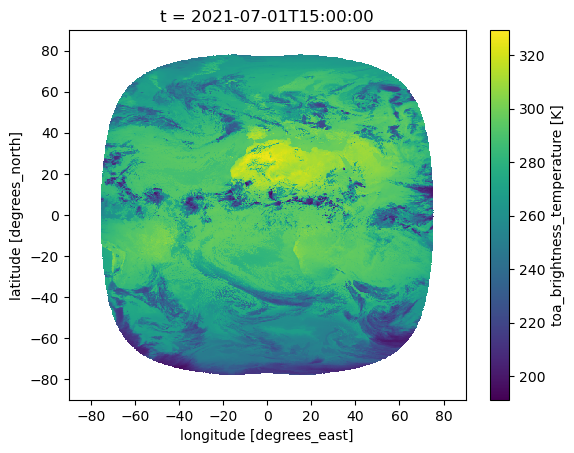

In [56]:
seviri_ds.bt.plot()

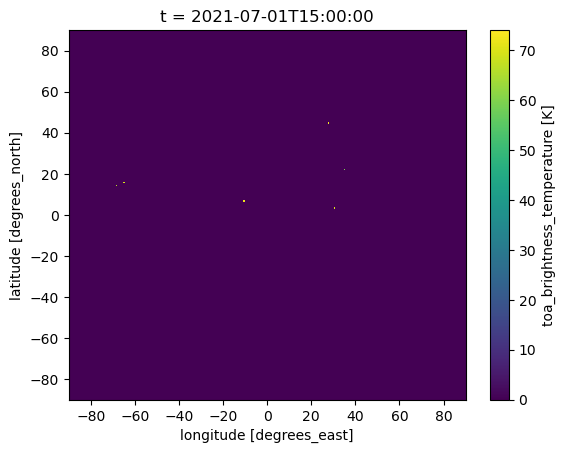

In [57]:
seviri_ds.core_labels.plot()

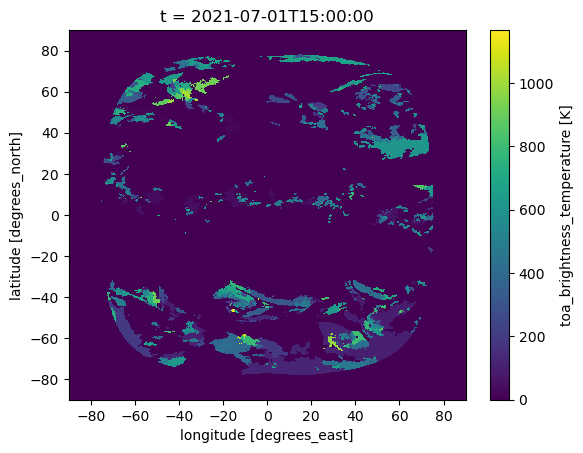

In [58]:
seviri_ds.thick_anvil_labels.plot()

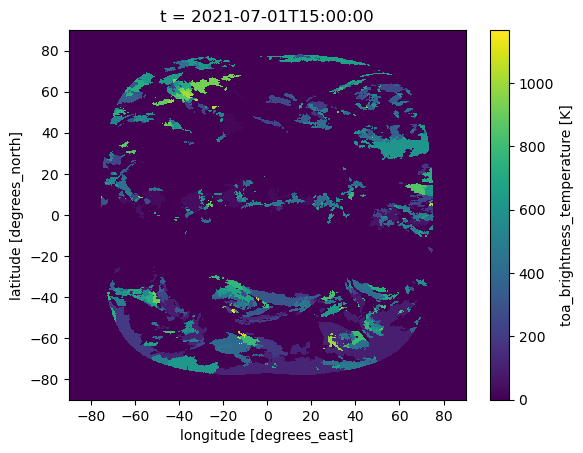

In [59]:
seviri_ds.thin_anvil_labels.plot()

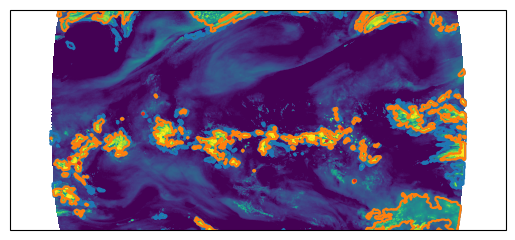

In [60]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([-90,90,-40,40], crs=ccrs.PlateCarree())
# ax.imshow(seviri_ds.bt, cmap="binary", vmax=320, vmin=180, extent=[-90,90,-90,90], origin="lower")
ax.imshow(seviri_ds.wvd, cmap="viridis", vmax=0, vmin=-20, extent=[-90,90,-90,90], origin="lower")

cntr = [
    ax.contour(seviri_ds.longitude, seviri_ds.latitude[::-1], seviri_ds.thin_anvil_labels>0, [0.5], colors=["C00"], transform_first=True), 
    ax.contour(seviri_ds.longitude, seviri_ds.latitude[::-1], seviri_ds.thick_anvil_labels>0, [0.5], colors=["C01"], transform_first=True), 
    ax.contour(seviri_ds.longitude, seviri_ds.latitude[::-1], seviri_ds.core_labels>0, [0.5], colors=["C03"], transform_first=True), 
]

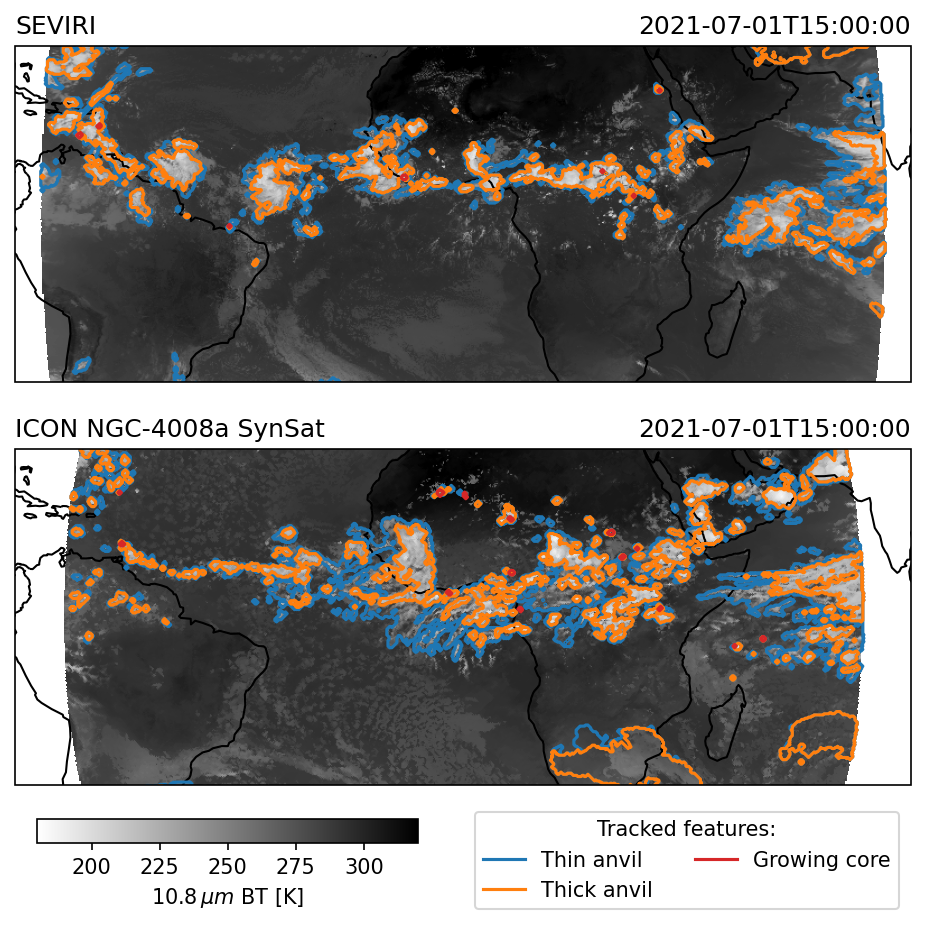

In [65]:
fig, axes = plt.subplots(2, 1, subplot_kw=dict(projection=ccrs.PlateCarree()), dpi=150, figsize=(8,6.4))
axes[0].set_extent([-80,80,-30,30], crs=ccrs.PlateCarree())
img = axes[0].imshow(seviri_ds.bt.values, cmap="binary", vmax=320, vmin=180, extent=[-90,90,-90,90], origin="upper")
# axes[0].imshow(seviri_ds.swd.values, cmap="RdBu", vmax=10, vmin=-10, extent=[-90,90,-90,90], origin="upper")
cntr = [
    axes[0].contour(seviri_ds.longitude, seviri_ds.latitude, seviri_ds.thin_anvil_labels>0, [0.5], colors=["C00"], transform_first=True), 
    axes[0].contour(seviri_ds.longitude, seviri_ds.latitude, seviri_ds.thick_anvil_labels>0, [0.5], colors=["C01"], transform_first=True), 
    axes[0].contour(seviri_ds.longitude, seviri_ds.latitude, seviri_ds.core_labels>0, [0.5], colors=["C03"], transform_first=True), 
]
axes[0].coastlines()
axes[0].set_title(f'SEVIRI', loc="left")
axes[0].set_title(f'{np.datetime64(seviri_ds.t.item(), "ns").astype("datetime64[s]")}', loc="right")

axes[1].set_extent([-80,80,-30,30], crs=ccrs.PlateCarree())
img = axes[1].imshow(synsat_ds.bt.values, cmap="binary", vmax=320, vmin=180, extent=[-90,90,-90,90], origin="lower")
# axes[1].imshow(synsat_ds.wvd.values, cmap="RdBu", vmax=0, vmin=-15, extent=[-90,90,-90,90], origin="lower")
cntr = [
    axes[1].contour(seviri_ds.longitude, seviri_ds.latitude[::-1], synsat_ds.thin_anvil_labels>0, [0.5], colors=["C00"], transform_first=True), 
    axes[1].contour(seviri_ds.longitude, seviri_ds.latitude[::-1], synsat_ds.thick_anvil_labels>0, [0.5], colors=["C01"], transform_first=True), 
    axes[1].contour(seviri_ds.longitude, seviri_ds.latitude[::-1], synsat_ds.core_labels>0, [0.5], colors=["C03"], transform_first=True), 
]
axes[1].coastlines()
axes[1].set_title(f'ICON NGC-4008a SynSat', loc="left")
axes[1].set_title(f'{np.datetime64(synsat_ds.t.item(), "ns").astype("datetime64[s]")}', loc="right")


ax_position = axes[1].get_position().bounds
ax_corner = ax_position[0]
ax_width = ax_position[2]

cax = fig.add_axes([ax_corner+ax_width*0.025, 0.05, ax_width*0.425, 0.025])
cbar = plt.colorbar(img, cax=cax, label=r"$10.8\,\mu m$ BT [K]", orientation="horizontal")

import matplotlib.lines as mlines

fig.legend(
    [mlines.Line2D([], [], color='C00'), mlines.Line2D([], [], color='C01'), mlines.Line2D([], [], color='C03')], 
    ['Thin anvil', 'Thick anvil', 'Growing core'], title="Tracked features:", 
    loc='center', bbox_to_anchor=(ax_corner + ax_width*0.5, -0.018, ax_width*0.5, 0.1), 
    ncol=2
)

In [66]:
save_dir = pathlib.Path("./seviri_synsat_frames")
save_dir.mkdir(parents=True, exist_ok=True)

In [68]:
fig.savefig(save_dir/f'seviri_synsat_{frame}.png')